In [ ]:
# This notebook uses GPy (Gaussian Processes module) to perform an advanced type of spatial regression (also known as kriging).
# We take elevation datapoints from OpenStreetMap and infer the surface contour of Britain.

In [1]:
# load the modules etc
%pylab inline
import numpy as np
import pylab as pb
import GPy
import csv
from operator import itemgetter
import json
import cPickle as pickle

Populating the interactive namespace from numpy and matplotlib


Loaded eledata from pickle
ele_scaler is 265.312
If data was on a square grid, the space between would be 0.450181


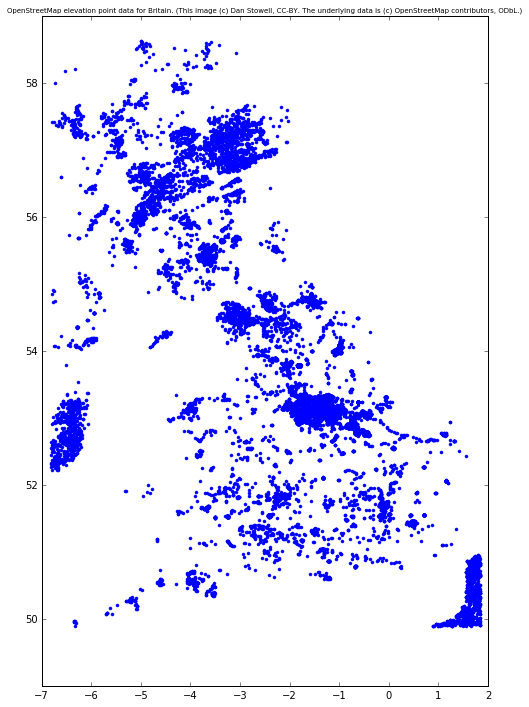

In [2]:
# Here we load the OSM elevation data, i.e. a set of nodes with the "ele" tag. Note that OSM is freeform so we have to be a bit careful about unexpected values.
picklepath = 'gb_ele.pickle'
try:
    # cache of data we already parsed
    eledata = pickle.load(open(picklepath, 'rb'))
    print "Loaded eledata from pickle"
except:
    with open('gb_ele.json', 'r') as fp:
        eledata = []
        failedcount = 0
        for item in json.load(fp)[u'elements']:
            try:
                eletag = item[u'tags'][u'ele']
                if eletag[-3:]==' ft':
                    eletag = float(eletag[:-3]) / 3.281
                elif eletag[-2:]==' m':
                    eletag = float(eletag[:-2])
                elif eletag[-1:]=='m':
                    eletag = float(eletag[:-1])
                else:
                    eletag = float(eletag)
                eledata.append([item[u'lon'], item[u'lat'], eletag])
            except ValueError:
                # Typically this is weirdly-expressed ele data such as "floor 1"
                #print "Failed to decode value: %s" % (item[u'tags'][u'ele'])
                failedcount += 1
            except KeyError:
                # Typically this is things like relations rather than nodes
                #print "KeyError: %s" % str(item)
                failedcount += 1
    print "Loaded %i ele vals, failed to load %i" % (len(eledata), failedcount)
    if len(eledata)>0:
        pickle.dump(eledata, open(picklepath, 'wb'), -1)
np.random.shuffle(eledata)

ele_scaler = np.sqrt(np.mean([item[2]**2 for item in eledata])) # This (the RMS) is the std, but centred around zero, not the mean. (We want zero to stay zero.)
print "ele_scaler is %g" % ele_scaler
eledata = [[x[0], x[1], x[2]/ele_scaler] for x in eledata] # rescale the elevations to RMS 1

minlat = np.min([item[1] for item in eledata])
minlon = np.min([item[0] for item in eledata])
maxlat = np.max([item[1] for item in eledata])
maxlon = np.max([item[0] for item in eledata])
print "If data was on a square grid, the space between would be %g" % ((maxlat-minlat)*(maxlon-minlon)/np.sqrt(len(eledata)))
fig = pb.figure()
fig.set_size_inches(8, 12)
pb.plot([item[0] for item in eledata], [item[1] for item in eledata], '.')
pb.title("OpenStreetMap elevation point data for Britain. (This image (c) Dan Stowell, CC-BY. The underlying data is (c) OpenStreetMap contributors, ODbL.)", fontsize="x-small")

Loaded coastdata from pickle


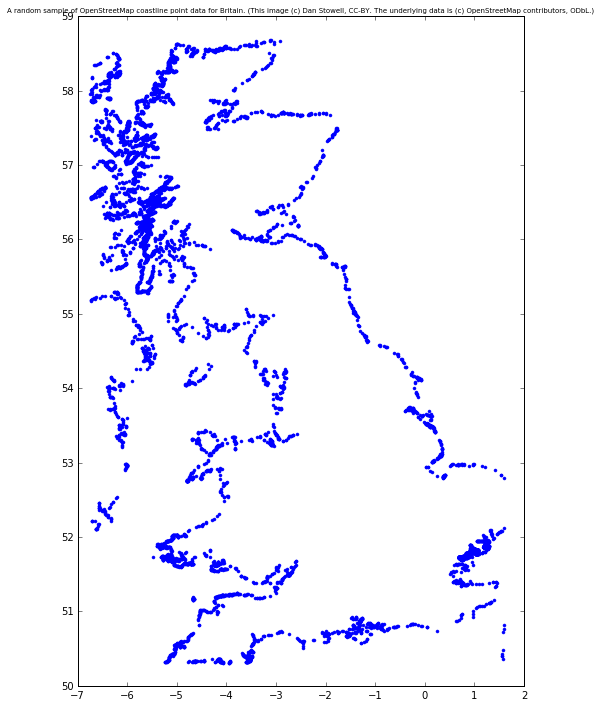

In [3]:
# let's also load the coastline, but keep it separate so we can mix it in to our liking (there are many more coastline points than ele points)
picklepath = 'gb_coastline.pickle'
try:
    # cache of data we already parsed
    coastdata = pickle.load(open(picklepath, 'rb'))
    print "Loaded coastdata from pickle"
except:
    with open('gb_coastline.json', 'r') as fp:
        coastdata = []
        failedcount = 0
        for item in json.load(fp)[u'elements']:
            try:
                coastdata.append([item[u'lon'], item[u'lat'], 0.0])
            except:
                #print "Failed to decode value: %s" % (item[u'tags'][u'ele'])
                failedcount += 1
    print "Loaded %i coastline points, failed to load %i" % (len(coastdata), failedcount)
    pickle.dump(coastdata, open(picklepath, 'wb'), -1)
np.random.shuffle(coastdata)
fig = pb.figure()
fig.set_size_inches(8, 12)
pb.plot([item[0] for item in coastdata[:10000]], [item[1] for item in coastdata[:10000]], '.')
pb.title("A random sample of OpenStreetMap coastline point data for Britain. (This image (c) Dan Stowell, CC-BY. The underlying data is (c) OpenStreetMap contributors, ODbL.)", fontsize="x-small")

 /Users/Vilstrup/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


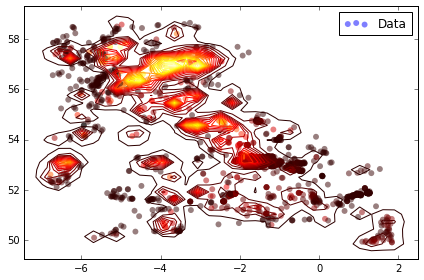

In [10]:
# Here we do an overall fit for a random subset of the data.
# It will not be very good, since our data will be too sparse to cover the UK, 
# though if we make it denser the computation time grows as n^3 so we can't simply do that.
k = GPy.kern.Exponential(input_dim=2, variance=1., lengthscale=0.1)  # Or maybe Matern32?
trimto = 2000
trimcoast = 500
Xin = np.array([[item[0], item[1]] for item in (eledata[:trimto] + coastdata[:trimcoast])])
Yin = np.array([[item[2]]          for item in (eledata[:trimto] + coastdata[:trimcoast])])
m = GPy.models.GPRegression(Xin, Yin, k)
fig = pb.figure()
fig.set_size_inches(8, 12)
m.plot(fignum=fig.number)

In [13]:
# Next: divide and conquer the task. run a set of lapped 1-degree-square patches, then sum them up.

# The first job (this code block) is to optimise the parameters we'll be using.

# all these values are in degrees
patchsize = 2
resn_lon = 0.025
resn_lat = 0.0125
totsize_lon = 9
totsize_lat = 8
corner_lon = -6.5
corner_lat = 50.5

loncens = np.arange(corner_lon, corner_lon + totsize_lon, patchsize * 0.5)
latcens = np.arange(corner_lat, corner_lat + totsize_lat, patchsize * 0.5)

# for each patch, a random subset will be used, in order to limit the computation - there are some really dense bits that would otherwise dominate the time taken
maxpointsperpatch = 1000
# we will infer the shape in overlapped patches, and so to sum them back together again we use a 2D Hann window to "crossfade" the patches
window2d = np.outer(np.hanning(int(patchsize/resn_lon)), np.hanning(int(patchsize/resn_lat)))

patchedimage = np.zeros((int((totsize_lon+patchsize) / resn_lon), int((totsize_lat+patchsize) / resn_lat)))

lenlimit = min(len(eledata), len(coastdata)) # we'll make sure neither the coast nor the others are over-represented
allpoints = eledata[:lenlimit] + coastdata[:lenlimit]

# Choose a covariance kernel
#k = GPy.kern.Matern32(input_dim=2, variance=1., lengthscale=0.1) + GPy.kern.bias(2)  # tested 0.01 and it was awful fragmentyness, 0.05 meh too, 0.1 good though a bit blobby
k = GPy.kern.Exponential(input_dim=2, variance=1., lengthscale=0.15) + GPy.kern.Bias(2)

# First we will do a fit to a reasonably representative patch of the UK, and optimise the kernel parameters using it
loncen = -1
latcen = 53
lonmin = loncen - (patchsize * 0.5)
lonmax = loncen + (patchsize * 0.5)
latmin = latcen - (patchsize * 0.5)
latmax = latcen + (patchsize * 0.5)
curpoints = filter(lambda p: p[0]>lonmin and p[0]<lonmax and p[1]>latmin and p[1]<latmax, allpoints)
np.random.shuffle(curpoints)
print len(curpoints)
curpoints = curpoints[:maxpointsperpatch]
print len(curpoints)
# fit a gp to this area
Xin = np.array([[item[0], item[1]] for item in curpoints])
Yin = np.array([[item[2]]          for item in curpoints])
m = GPy.models.GPRegression(Xin, Yin, k)
m.optimize(messages=1)
# NOTE: this will run for a while. You can stop it at any time and get improved-but-not-locally-optimal params

17921
1000


In [14]:
print m  # shows the learnt parameters


Name : GP regression
Objective : -705.11055279
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.               |             value  |  constraints  |  priors
  sum.Exponential.variance     |    0.153398169743  |      +ve      |        
  sum.Exponential.lengthscale  |    0.197549896978  |      +ve      |        
  sum.bias.variance            |    0.106535950017  |      +ve      |        
  Gaussian_noise.variance      |  0.00214889955435  |      +ve      |        


In [17]:
# First we grab the learnt parameters from the above run
k = m.kern
noisevar = m['Gaussian_noise.variance']
# Now we do the full fit, iterating in patches over the whole area.
# NOTE: running this code block will still take a while, but nowhere near as long as trying to push it all through one grand inference.
for whichlatcen, latcen in enumerate(latcens):
    rowcount = 0
    rowavailcount = 0
    for whichloncen, loncen in enumerate(loncens):
        imgoff_lon = int((loncen - corner_lon)/resn_lon)
        imgoff_lat = int((latcen - corner_lat)/resn_lat)
        lonmin = loncen - (patchsize * 0.5)
        lonmax = loncen + (patchsize * 0.5)
        latmin = latcen - (patchsize * 0.5)
        latmax = latcen + (patchsize * 0.5)
        curpoints = filter(lambda p: p[0]>lonmin and p[0]<lonmax and p[1]>latmin and p[1]<latmax, allpoints)
        if len(curpoints)==0:
            continue
        np.random.shuffle(curpoints)
        rowavailcount += len(curpoints)
        curpoints = curpoints[:maxpointsperpatch]
        rowcount += len(curpoints)
        # fit a gp to this area
        Xin = np.array([[item[0], item[1]] for item in curpoints])
        Yin = np.array([[item[2]]          for item in curpoints])
        onem = GPy.models.GPRegression(Xin, Yin, k)
        onem['Gaussian_noise.variance'] = noisevar
        # get a grid
        alongrid = np.arange(lonmin, lonmax, resn_lon)
        alatgrid = np.arange(latmin, latmax, resn_lat)
        agrid = []
        for lat in alatgrid:
            agrid.append(onem.predict(np.array([[lon, lat] for lon in alongrid]))[0].flatten())
        # add our grid onto the grand one
        agrid = np.array(agrid).T
        #print agrid.shape
        agrid *= window2d
        patchedimage[imgoff_lon:imgoff_lon+np.shape(agrid)[0],  imgoff_lat:imgoff_lat+np.shape(agrid)[1]] += agrid
    print "Done row %i/%i. Used %i points out of a potential %i." % (whichlatcen, len(latcens), rowcount, rowavailcount)
print "Done."

Done row 0/8. Used 6988 points out of a potential 8410.
Done row 1/8. Used 8232 points out of a potential 31382.
Done row 2/8. Used 8794 points out of a potential 64345.
Done row 3/8. Used 7929 points out of a potential 44326.
Done row 4/8. Used 7122 points out of a potential 11872.
Done row 5/8. Used 6435 points out of a potential 17046.
Done row 6/8. Used 5434 points out of a potential 19278.
Done row 7/8. Used 5263 points out of a potential 15110.
Done.


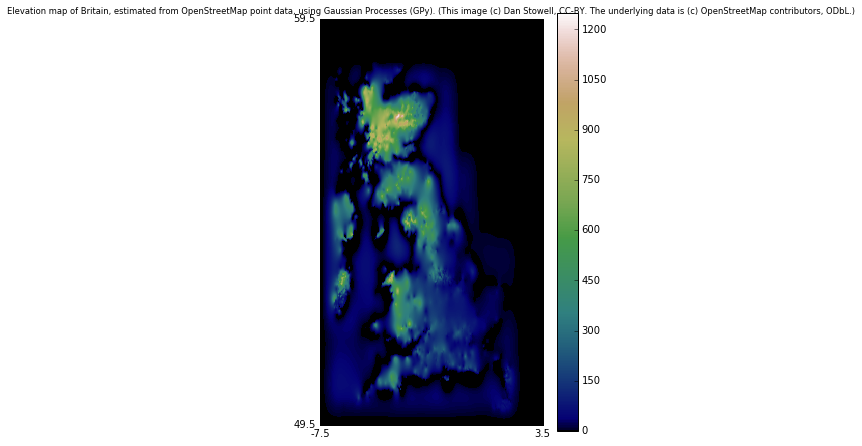

In [21]:
fig = pb.figure()
fig.set_size_inches(5, 7.5)
pb.imshow(np.maximum(0, patchedimage.T * ele_scaler), origin='lower', interpolation='nearest') #, vmin=-10)
pb.xticks([0, patchedimage.shape[0]-1], [corner_lon - patchsize * 0.5, corner_lon + totsize_lon + patchsize * 0.5])
pb.yticks([0, patchedimage.shape[1]-1], [corner_lat - patchsize * 0.5, corner_lat + totsize_lat + patchsize * 0.5])
pb.set_cmap('gist_earth')
pb.colorbar()
pb.title("Elevation map of Britain, estimated from OpenStreetMap point data, using Gaussian Processes (GPy). (This image (c) Dan Stowell, CC-BY. The underlying data is (c) OpenStreetMap contributors, ODbL.)", fontsize="small")